**Sistemas de Apoio à Decisão**
# **Trabalho Prático II - Tarefas de Mineração de Dados: Classificação**

- Kassio Rodrigues Ferreira - 19.1.8139
- Matues Costa 20.1.8025


# Dataset HTRU2 (Pulsar Detection)

## 1. Introdução

Este projeto tem como objetivo a aplicação de técnicas de mineração de dados para resolver um problema de classificação binária: distinguir entre **pulsars reais** e **falsos positivos** em sinais de rádio captados por telescópios.

A base de dados utilizada é a **HTRU2 (High Time Resolution Universe Survey)**, disponível no repositório da UCI Machine Learning. A tarefa consiste em prever, a partir de estatísticas extraídas dos sinais, se uma amostra representa ou não um pulsar.

- Link para o dataset: https://archive.ics.uci.edu/dataset/372/htru2

### 1.1 Sobre o Dataset HTRU2

O conjunto de dados **HTRU2** foi criado a partir de sinais de rádio captados por telescópios, com o objetivo de identificar **pulsars** — estrelas de nêutrons que emitem feixes de radiação de forma periódica, como um farol no espaço.

Detectar esses sinais é desafiador, pois a maioria dos registros captados é composta por **ruídos ou interferências**, vindos de transmissões humanas ou outros fenômenos cósmicos. O grande desafio é diferenciar os sinais legítimos (pulsars reais) dos **falsos positivos**.

Para isso, cada amostra do dataset é descrita por estatísticas extraídas de duas representações do sinal:

- **Perfil Integrado**: mostra como o sinal varia ao longo do tempo.
- **Curva DM-SNR**: mostra como o sinal se comporta ao variar o valor da dispersão (um fenômeno causado pela presença de partículas entre a estrela e a Terra).

De cada uma dessas curvas, foram extraídas quatro medidas estatísticas que ajudam a caracterizar o sinal:

- **Média**: valor médio da curva; sinais de pulsars tendem a ter médias mais elevadas em função da presença de picos regulares.
- **Desvio padrão**: mostra o quanto o sinal oscila em torno da média; pulsares costumam apresentar maior variação por conta da repetição de pulsos intensos.
- **Curtose**: detecta picos acentuados; sinais de pulsars geralmente exibem curtose alta devido aos pulsos bem definidos.
- **Assimetria**: avalia se o sinal é balanceado ou inclinado para um dos lados; em muitos casos, pulsares apresentam assimetria positiva ou negativa dependendo do formato do pulso captado.


## 2. Características da Base de Dados

- **Total de amostras:** 17.898
- **Classes:**
  - `0`: Não-pulsar (16.259 amostras)
  - `1`: Pulsar (1.639 amostras)

- **Atributos:** 8 estatísticas descritivas dos sinais baseadas em duas curvas extraídas do sinal original: **curva integrada** e **curva DM-SNR**.

Para cada tipo de curva, foram extraídas 4 estatísticas, e os atributos foram renomeados para português visando facilitar a análise:

- **Perfil Integrado**
  - Média, Desvio Padrão, Curtose, Assimetria

- **Curva DM-SNR**
  - Média, Desvio Padrão, Curtose, Assimetria

## 3. Etapas de Pré-processamento

- **Análise exploratória de dados:** distribuição das variáveis e matriz de correlação entre variáveis.

- **Remoção de colunas altamente correlacionadas:** `assimetria_perfil_integrado` e `assimetria_curva_dm_snr` foram removidas por apresentarem correlação superior a 90% com outras variáveis.

- **Verificação de valores ausentes:** nenhuma ocorrência de valores nulos foi detectada.

- **Normalização dos dados:** os dados foram padronizados com `StandardScaler` (z-score), garantindo média zero e desvio padrão 1 para cada atributo.

- **Balanceamento das classes:** como a classe 0 representava mais de 90% das amostras, aplicou-se **undersampling com NearMiss (versão 1)**. Resultado:
  - 1.639 amostras de cada classe
  - Total: 3.278 amostras

## 4. Treinamento

- Foi utilizado o algoritmo **Random Forest Classifier**, com validação cruzada `StratifiedKFold` (5 folds) e otimização de hiperparâmetros via `GridSearchCV`.
- O modelo foi treinado e avaliado em cada fold de forma independente.

## 5. Resultados

### Principais métricas (média entre os folds):

| Métrica      | Valor Médio |
|--------------|-------------|
| Acurácia     | ~95,28%     |
| Precisão     | ~95,39%     |
| Recall       | ~95,24%     |
| F1-Score     | ~95,24%     |

### Importância das Features (top 3):

1. `curtose_perfil_integrado`
2. `media_perfil_integrado`
3. `curtose_curva_dm_snr`

## Referências

R. Lyon. "HTRU2," UCI Machine Learning Repository, 2015. [Online]. Available: https://doi.org/10.24432/C5DK6R.

Lyon, R.J., Stappers, B.W., Cooper, S., Brooke, J.M., & Knowles, J.D. (2016). Fifty years of pulsar candidate selection: from simple filters to a new principled real-time classification approach. Monthly Notices of the Royal Astronomical Society, 459, 1104-1123.

# **Código**

## 1. Bibliotecas e dependências

In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix #

from imblearn.under_sampling import NearMiss
from tqdm import tqdm

from ucimlrepo import fetch_ucirepo # UCI repo - Para baixar o repositório pela lib do UCI

### 1.2 Importando a Base de dados

In [3]:
# Importando via ucimlrepo
htru2 = fetch_ucirepo(id=372)
X = htru2.data.features
y = htru2.data.targets

# Carregando em um dataframe Pandas
df_base = pd.concat([X, y], axis=1)

df_base.columns = [
    "media_perfil_integrado",
    "desvio_padrao_perfil_integrado",
    "curtose_perfil_integrado",
    "assimetria_perfil_integrado",
    "media_curva_dm_snr",
    "desvio_padrao_curva_dm_snr",
    "curtose_curva_dm_snr",
    "assimetria_curva_dm_snr",
    "classe"
]

# Verificando
print("Shape:", df_base.shape)
print("Classes:")
print(df_base["classe"].value_counts())
df_base.head()

Shape: (17898, 9)
Classes:
classe
0    16259
1     1639
Name: count, dtype: int64


,media_perfil_integrado,desvio_padrao_perfil_integrado,curtose_perfil_integrado,assimetria_perfil_integrado,media_curva_dm_snr,desvio_padrao_curva_dm_snr,curtose_curva_dm_snr,assimetria_curva_dm_snr,classe
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


## 2. Análise do Dataset

Nesta etapa, é feita uma análise inicial da base de dados para verificar suas características e como devemos preparar a base.

### 2.1 Correlação dos atributos

In [4]:
# Estatísticas descritivas
display(df_base.describe())

,media_perfil_integrado,desvio_padrao_perfil_integrado,curtose_perfil_integrado,assimetria_perfil_integrado,media_curva_dm_snr,desvio_padrao_curva_dm_snr,curtose_curva_dm_snr,assimetria_curva_dm_snr,classe
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


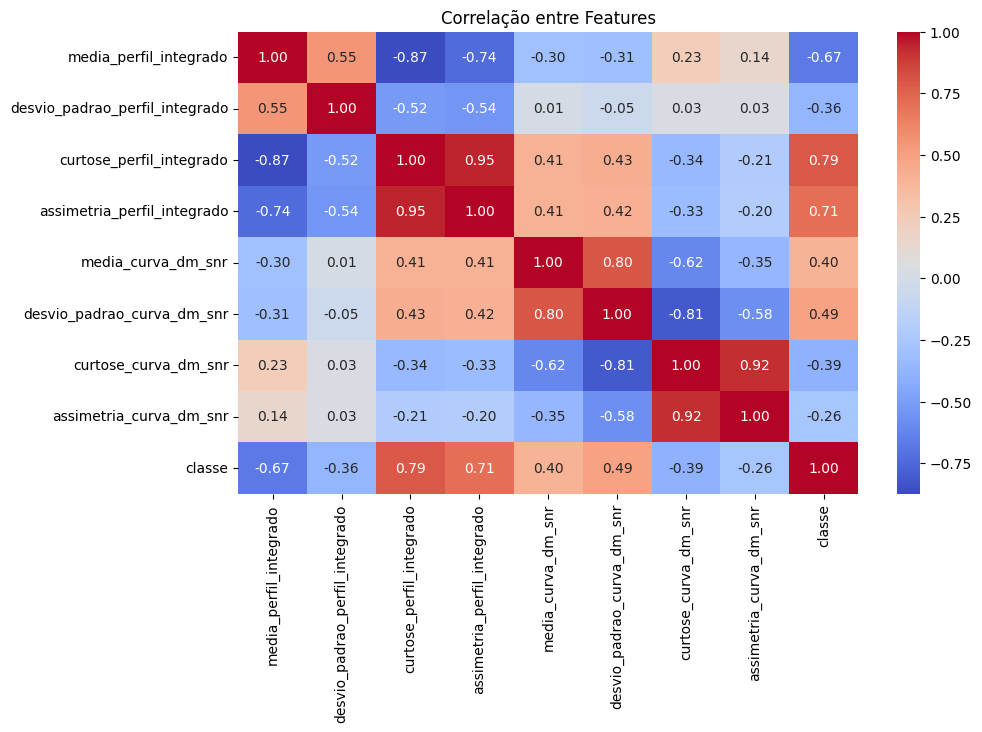

In [5]:
# Heatmap de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(df_base.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlação entre Features")
plt.show()

In [6]:
# Avaliando correlações

# Copia do DataFrame original
df_corr = df_base.copy()

# Calcula a matriz de correlação (pearson, padrão)
correlation_matrix = df_corr.corr()

# Converte para porcentagem para facilitar leitura
correlation_percentage = correlation_matrix * 100

# Define o limiar de correlação forte
limiar = 50

# Filtra pares com correlação acima do limiar (em valor absoluto), exceto autocorrelações (100%)
filtered = correlation_percentage[
    (correlation_percentage.abs() > limiar) & (correlation_percentage.abs() < 100)
]

# Empilha a matriz filtrada para transformar em DataFrame plano
correlacoes_empilhadas = filtered.stack().reset_index()
correlacoes_empilhadas.columns = ['Variável 1', 'Variável 2', 'Correlação (%)']

# Cria um identificador único para cada par (ordem alfabética)
correlacoes_empilhadas['Par de Variáveis'] = correlacoes_empilhadas.apply(
    lambda row: '-'.join(sorted([row['Variável 1'], row['Variável 2']])), axis=1
)

# Remove pares duplicados (ex: A-B e B-A)
correlacoes_empilhadas = correlacoes_empilhadas.drop_duplicates(subset='Par de Variáveis')

# Ordena por correlação absoluta decrescente
correlacoes_empilhadas = correlacoes_empilhadas.sort_values(by='Correlação (%)', ascending=False, key=abs)

# Remove a coluna auxiliar antes de exibir
correlacoes_empilhadas = correlacoes_empilhadas.drop(columns=['Par de Variáveis'])

# Exibe o resultado
if not correlacoes_empilhadas.empty:
    print(f"\n Correlações acima de {limiar}% entre features:")
    from tabulate import tabulate
    print(tabulate(correlacoes_empilhadas, headers='keys', tablefmt='grid', showindex=False))
else:
    print("Nenhuma correlação acima do limiar foi encontrada.")



 Correlações acima de 50% entre features:
+--------------------------------+--------------------------------+------------------+
| Variável 1                     | Variável 2                     |   Correlação (%) |
+================================+================================+==================+
| curtose_perfil_integrado       | assimetria_perfil_integrado    |          94.5729 |
+--------------------------------+--------------------------------+------------------+
| curtose_curva_dm_snr           | assimetria_curva_dm_snr        |          92.3743 |
+--------------------------------+--------------------------------+------------------+
| media_perfil_integrado         | curtose_perfil_integrado       |         -87.3898 |
+--------------------------------+--------------------------------+------------------+
| desvio_padrao_curva_dm_snr     | curtose_curva_dm_snr           |         -80.9786 |
+--------------------------------+--------------------------------+------------------+


### 2.2 Distribuição das Classes

(17898, 9)
classe
0    16259
1     1639
Name: count, dtype: int64


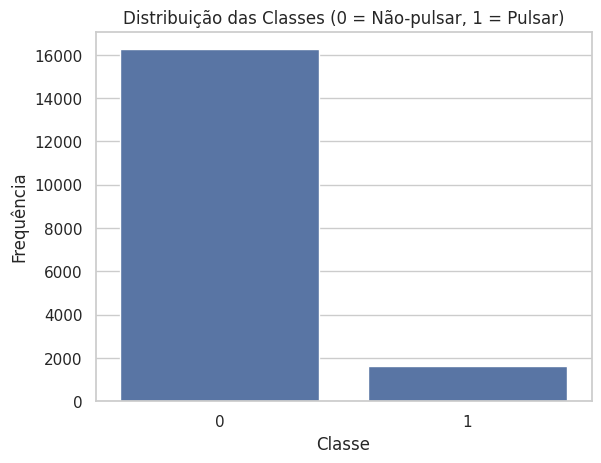

In [7]:
# Estilo dos gráficos
sns.set(style="whitegrid")

# Distribuição das classes
print(df_base.shape)
print(df_base["classe"].value_counts())

sns.countplot(x='classe', data=df_base)
plt.title("Distribuição das Classes (0 = Não-pulsar, 1 = Pulsar)")
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.show()

### 2.3 Verifica se a base possui colunas com valores nulos

In [8]:
# Verifica a quantidade total de valores nulos por coluna
nulos_por_coluna = df_base.isnull().sum()

# Exibe apenas colunas com pelo menos 1 valor nulo
nulos_detectados = nulos_por_coluna[nulos_por_coluna > 0]

if nulos_detectados.empty:
    print("Nenhum valor nulo detectado no dataset.")
else:
    print("Colunas com valores nulos:")
    print(nulos_detectados)

Nenhum valor nulo detectado no dataset.


## 3 Pré-processamento

A partir da análise inicial do dataset, foi possível identificar a necessidade dos seguintes pré-processamentos:

1. Temos algumas variávels com um alto grau de correlação, e por tanto, vamos eliminar as seguintes variáveis:
  - `assimetria_perfil_integrado`
  - `assimetria_curva_dm_snr`

2. Aplicar a normalização dos valores com o StandarScaler (z-score)
  - com média 0 e desvio = 1

3. Por fim, vemos que há um grande desbalanceamento de classes, sendo que a classe `1` (Pulsar) possui apenas 1.639 amostras, enquanto a classe `2` (Não-Pulsar) possui 16.259 amostras.

  - Por tanto, também será aplicado um undersampling utilizando a abordagem NearMiss para balancear o dataset.

### 3.1 Removendo variáveis altamente correlacionadas

In [9]:
# Removendo variáveis altamente correlacionadas
df_reduzido = df_base.drop(columns=[
    "assimetria_perfil_integrado",
    "assimetria_curva_dm_snr"
])
print("Dataset reduzido:", df_reduzido.shape)

Dataset reduzido: (17898, 7)


### 3.2 Normalização dos valores - StandardScaler (z-score)

In [10]:
# Normalizando com com média 0 e desvio = 1 | StandardScaler (z-score)
# Separando features e alvo
X = df_reduzido.drop(columns=["classe"])
y = df_reduzido["classe"]

# Aplicando a padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertendo de volta para DataFrame (opcional, útil para visualização)
import numpy as np
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# # Verificando
# print("📊 Features padronizadas (amostras iniciais):")
# print(X_scaled_df.head())

# Criando o DataFrame final com valores padronizados + classe
df_padronizado = pd.concat([X_scaled_df, y.reset_index(drop=True)], axis=1)

# Verificação rápida
print("Dataset padronizado:")
print(df_padronizado.shape)
print(df_padronizado["classe"].value_counts())
# display(df_padronizado.describe())
df_padronizado.head()

Dataset padronizado:
(17898, 7)
classe
0    16259
1     1639
Name: count, dtype: int64


,media_perfil_integrado,desvio_padrao_perfil_integrado,curtose_perfil_integrado,media_curva_dm_snr,desvio_padrao_curva_dm_snr,curtose_curva_dm_snr,classe
0,1.149317,1.334832,-0.669570,-0.319440,-0.370625,-0.072798,0
1,-0.334168,1.802265,-0.011785,-0.371102,-0.588924,0.504427,0
2,-0.314372,-1.053322,-0.145233,-0.322107,-0.235328,-0.125996,0
3,1.000694,1.553254,-0.513409,-0.304404,-0.275666,-0.312265,0
4,-0.871402,-0.858879,0.115609,-0.388010,-0.763111,1.324026,0


### 3.3 Balanceamento das classes via Undersampling (NearMiss)


Dataset balanceado com NearMiss:
(3278, 7)
classe
0    1639
1    1639
Name: count, dtype: int64


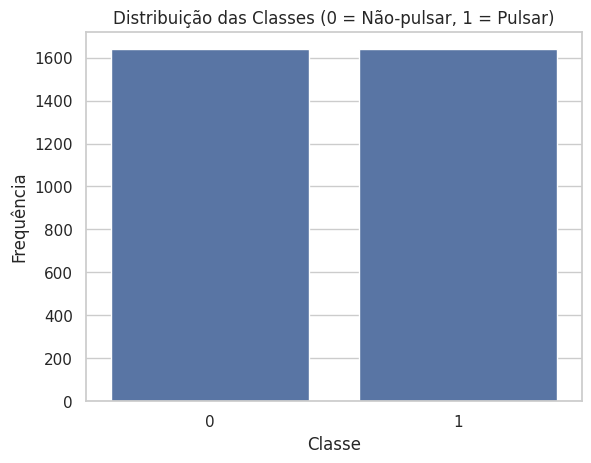

In [11]:
# Separando novamente features e alvo (do DataFrame padronizado)
X_padronizado = df_padronizado.drop(columns=["classe"])
y_padronizado = df_padronizado["classe"]

# Aplicando NearMiss
nearmiss = NearMiss(version=1)  # versão 1 usa média da distância dos 3 vizinhos mais próximos
X_res, y_res = nearmiss.fit_resample(X_padronizado, y_padronizado)

# Convertendo para DataFrame final balanceado
df_balanceado = pd.DataFrame(X_res, columns=X_padronizado.columns)
df_balanceado["classe"] = y_res.values

# Verificando resultado
print("\nDataset balanceado com NearMiss:")
print(df_balanceado.shape)
print(df_balanceado["classe"].value_counts())

sns.countplot(x='classe', data=df_balanceado)
plt.title("Distribuição das Classes (0 = Não-pulsar, 1 = Pulsar)")
plt.xlabel("Classe")
plt.ylabel("Frequência")
plt.show()

## 4 Classificação

Com a base de dados tratada, temos o necessário para definir o modelo de treinamento.

Neste trabalho, será utilizado o modelo de classificação `RANDOM FOREST` combinado com a validação cruzada com StratifiedKFold (5 folds) e GridSearchCV para otimização de hiperparâmetros do Random Forest.

### 4.1 Função de treinamento

In [12]:
# Função de treinamento
def random_forest_cv(X, y, n_splits, param_grid, base_name="Random Forest"):
    metrics_classificador = []
    all_conf_matrices = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_index, test_index in tqdm(skf.split(X, y), total=skf.get_n_splits(), desc=f"Validação Cruzada - {base_name}"):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        # Dividimos o conjunto de treino em treino/validação
        X_train_inner, X_val_inner, y_train_inner, y_val_inner = train_test_split(
            X_train_fold, y_train_fold, test_size=1/3, stratify=y_train_fold, random_state=42
        )

        # Grid Search nos dados de validação
        grid_search = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_grid=param_grid,
            cv=3,
            scoring='f1_macro',
            verbose=0
        )
        grid_search.fit(X_val_inner, y_val_inner)
        best_model = grid_search.best_estimator_

        # Treina o modelo final no conjunto interno de treino
        best_model.fit(X_train_inner, y_train_inner)

        # Avalia no conjunto de teste do fold
        y_pred = best_model.predict(X_test_fold)

        # Métricas
        conf_matrix = confusion_matrix(y_test_fold, y_pred)
        all_conf_matrices.append(conf_matrix)

        metrics_classificador.append({
            'Accuracy': accuracy_score(y_test_fold, y_pred),
            'Precision': precision_score(y_test_fold, y_pred, average='macro', zero_division=0),
            'Recall': recall_score(y_test_fold, y_pred, average='macro'),
            'F1-Score': f1_score(y_test_fold, y_pred, average='macro')
        })

    return metrics_classificador, all_conf_matrices, best_model

### 4.2 Execução do treinamento

In [13]:
# Separando features e classe
X = df_balanceado.drop(columns=["classe"])
y = df_balanceado["classe"]

# Definindo uma grade de hiperparâmetros simples para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

# Treinando
metricas_rf, matrizes_rf, modelo_rf_final = random_forest_cv(X, y, n_splits=5, param_grid=param_grid_rf)

Validação Cruzada - Random Forest: 100%|██████████| 5/5 [01:24<00:00, 16.87s/it]


## Resultados

### 4.1 Acurácia, precisão, revocação e f1-score

In [14]:
pd.DataFrame(metricas_rf)

,Accuracy,Precision,Recall,F1-Score
0,0.940549,0.943123,0.940549,0.940462
1,0.955793,0.956306,0.955793,0.955780
2,0.955793,0.957020,0.955793,0.955763
3,0.955725,0.955841,0.955713,0.955721
4,0.954198,0.954259,0.954208,0.954198


<ipython-input-15-40c2848d402e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_medias, x='Métrica', y='Valor Médio', palette='crest')


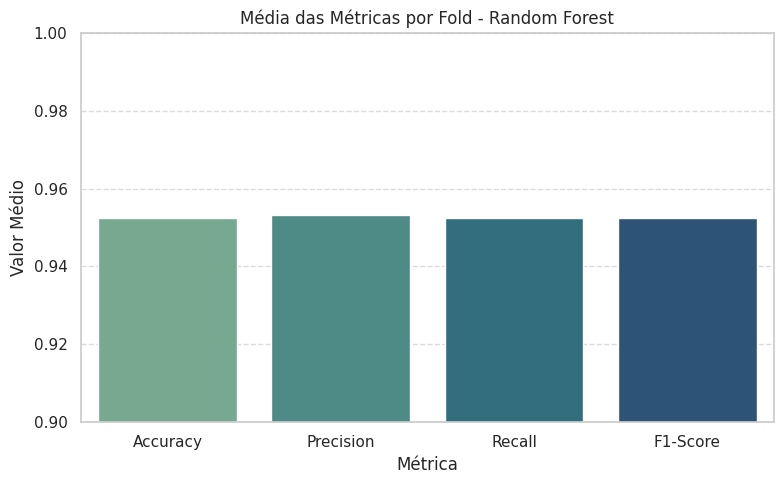

In [15]:
# DataFrame com as métricas por fold
df_metricas = pd.DataFrame(metricas_rf)

# Calcula a média de cada métrica
medias = df_metricas.mean()

# Converte para DataFrame para plotagem
df_medias = medias.reset_index()
df_medias.columns = ['Métrica', 'Valor Médio']

# Gráfico de barras
plt.figure(figsize=(8, 5))
sns.barplot(data=df_medias, x='Métrica', y='Valor Médio', palette='crest')
plt.title('Média das Métricas por Fold - Random Forest')
plt.ylim(0.9, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 4.2 Matriz de Confusão

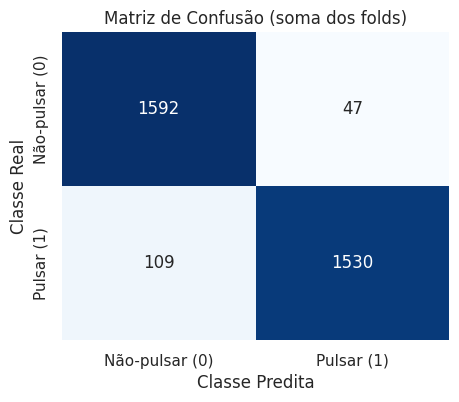

In [16]:
# Somando todas as matrizes de confusão dos folds
matriz_total = np.sum(matrizes_rf, axis=0)

# Exibindo como gráfico
plt.figure(figsize=(5, 4))
sns.heatmap(matriz_total, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão (soma dos folds)")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.xticks([0.5, 1.5], ['Não-pulsar (0)', 'Pulsar (1)'])
plt.yticks([0.5, 1.5], ['Não-pulsar (0)', 'Pulsar (1)'])
plt.show()

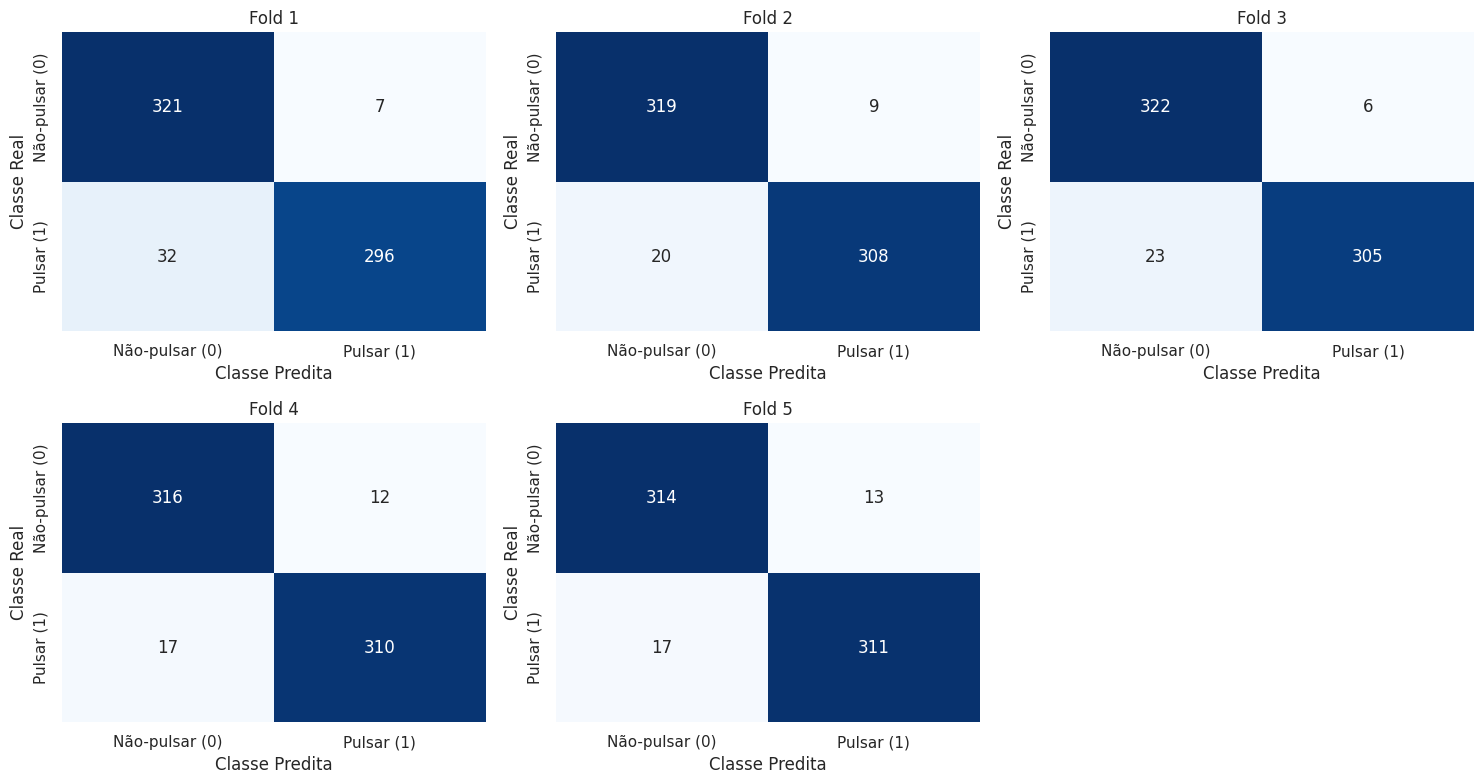

In [17]:

# Número total de folds
n_folds = len(matrizes_rf)

# Configura layout (ex: 2 linhas x 3 colunas para até 6 folds)
ncols = 3
nrows = (n_folds + ncols - 1) // ncols

# Criando subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
axes = axes.flatten()

# Loop pelos folds
for i, matriz in enumerate(matrizes_rf):
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Classe Predita")
    axes[i].set_ylabel("Classe Real")
    axes[i].set_xticklabels(['Não-pulsar (0)', 'Pulsar (1)'])
    axes[i].set_yticklabels(['Não-pulsar (0)', 'Pulsar (1)'])

# Remove gráficos extras, se existirem
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 4.3 Importância das Features na classificação

                          Feature  Importância
2        curtose_perfil_integrado     0.279018
0          media_perfil_integrado     0.233619
3              media_curva_dm_snr     0.204692
4      desvio_padrao_curva_dm_snr     0.140447
5            curtose_curva_dm_snr     0.098436
1  desvio_padrao_perfil_integrado     0.043788


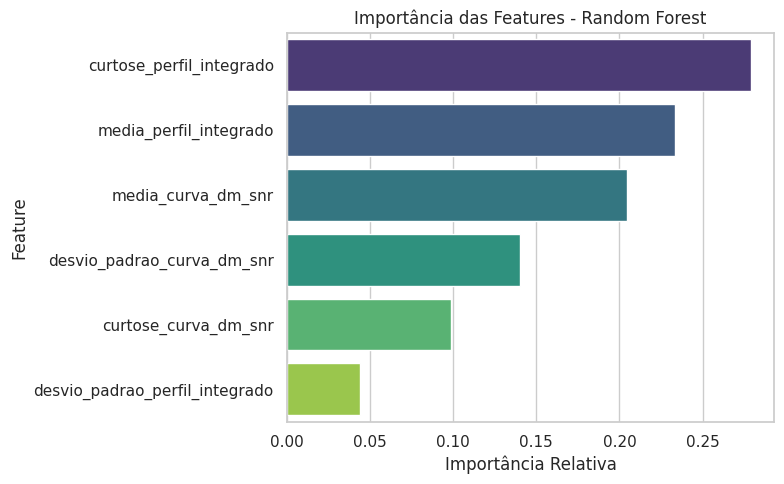

In [18]:
# Pegando os nomes das features (após normalização)
feature_names = df_balanceado.drop(columns=["classe"]).columns

# Extraindo importâncias do modelo
importancias = modelo_rf_final.feature_importances_

# DataFrame com os valores
df_importancia = pd.DataFrame({
    "Feature": feature_names,
    "Importância": importancias
}).sort_values(by="Importância", ascending=False)

# Exibindo
print(df_importancia)

# Plotando
plt.figure(figsize=(8, 5))
sns.barplot(data=df_importancia, x="Importância", y="Feature", hue="Feature", palette="viridis", legend=False)
plt.title("Importância das Features - Random Forest")
plt.xlabel("Importância Relativa")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()